<a href="https://colab.research.google.com/github/PabloCGarcia/deepLearning/blob/main/Clase04_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!/root/miniconda/bin/conda info -e

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:36
🔁 Restarting kernel...
# conda environments:
#
base                  *  /root/miniconda
                         /usr/local



In [ ]:
!conda install -y -c conda-forge rdkit deepchem selfies mlflow 
import deepchem
deepchem.__version__

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - deepchem
    - mlflow
    - rdkit
    - selfies


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alembic-1.0.9              |           py37_0         234 KB
   

'2.5.0'

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

import deepchem as dc
from deepchem.models.normalizing_flows import NormalizingFlow, NormalizingFlowModel
from deepchem.models.optimizers import Adam
from deepchem.data import NumpyDataset
from deepchem.splits import RandomSplitter
from deepchem.molnet import load_tox21

import rdkit
from rdkit.Chem import Draw

from IPython.display import Image, display

import selfies as sf

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

tfk.backend.set_floatx('float64')

In [ ]:
tasks, datasets, transformers = dc.molnet.load_qm9(featurizer='ECFP')
df = pd.DataFrame(data={'smiles': datasets[0].ids})

In [ ]:
data = df[['smiles']].sample(2500, random_state=50)

In [ ]:
data.head()

,smiles
3670,[H]C1=C([H])C([H])(C(F)(F)F)C([H])([H])C1([H])[H]
12694,[H]C([H])([H])C([H])([H])C1(C([H])([H])[H])C2(...
7790,[H]Oc1nc(N([H])C([H])([H])C([H])([H])[H])nn1[H]
23035,[H]C(=O)C([H])([H])C([H])([H])c1nc([H])n([H])c...
9969,[H]C#CC([H])(O[H])C([H])([H])C1([H])C([H])([H]...


In [ ]:
sf.set_semantic_constraints()  # reset constraints
constraints = sf.get_semantic_constraints()
constraints['?'] = 3

sf.set_semantic_constraints(constraints)
constraints

{'?': 3,
 'Br': 1,
 'C': 4,
 'C+1': 5,
 'C-1': 3,
 'Cl': 1,
 'F': 1,
 'H': 1,
 'I': 1,
 'N': 3,
 'N+1': 4,
 'N-1': 2,
 'O': 2,
 'O+1': 3,
 'O-1': 1,
 'P': 5,
 'P+1': 6,
 'P-1': 4,
 'S': 6,
 'S+1': 7,
 'S-1': 5}

In [ ]:
def preprocess_smiles(smiles):
  return sf.encoder(smiles)  

data['selfies'] = data['smiles'].apply(preprocess_smiles)

In [ ]:
data.head()

,smiles,selfies
3670,[H]C1=C([H])C([H])(C(F)(F)F)C([H])([H])C1([H])[H],[Hexpl][C][=C][Branch1_1][C][Hexpl][C][Branch1...
12694,[H]C([H])([H])C([H])([H])C1(C([H])([H])[H])C2(...,[Hexpl][C][Branch1_1][C][Hexpl][Branch1_1][C][...
7790,[H]Oc1nc(N([H])C([H])([H])C([H])([H])[H])nn1[H],[Hexpl][O][C][=N][C][Branch2_1][Ring1][Ring2][...
23035,[H]C(=O)C([H])([H])C([H])([H])c1nc([H])n([H])c...,[Hexpl][C][Branch1_2][C][=O][C][Branch1_1][C][...
9969,[H]C#CC([H])(O[H])C([H])([H])C1([H])C([H])([H]...,[Hexpl][C][#C][C][Branch1_1][C][Hexpl][Branch1...


In [ ]:
data['len'] = data['smiles'].apply(lambda x: len(x))
data.sort_values(by='len').head()

,smiles,selfies,len
73896,[H]C#CC#CC#C[H],[Hexpl][C][#C][C][#C][C][#C][Hexpl],15
11375,[H][C]C#C[NH3+],[Hexpl][Cexpl][C][#C][NH3+expl],15
14869,[H]C#CC#CC(=O)C#N,[Hexpl][C][#C][C][#C][C][Branch1_2][C][=O][C][#N],17
64222,N#CC(C#N)(C#N)C#N,[N][#C][C][Branch1_1][Ring1][C][#N][Branch1_1]...,17
96905,[H]c1nonc([H])c1=O,[Hexpl][C][=N][O][N][=C][Branch1_1][C][Hexpl][...,18


In [ ]:
data[data["selfies"].str.contains("\.") ].index

Int64Index([5, 94038], dtype='int64')

In [ ]:
filtro = data[data["selfies"].str.contains("\.") ].index
data.drop(index=filtro, inplace=True)

In [ ]:
selfies_list=data.selfies.to_list()

In [ ]:
selfies_list[0]

'[Hexpl][C][=C][Branch1_1][C][Hexpl][C][Branch1_1][C][Hexpl][Branch1_1][Branch2_2][C][Branch1_1][C][F][Branch1_1][C][F][F][C][Branch1_1][C][Hexpl][Branch1_1][C][Hexpl][C][Ring1][=N][Branch1_1][C][Hexpl][Hexpl]'

In [ ]:
#selfies_list = np.asanyarray(data.selfies)
selfies_alphabet = sf.get_alphabet_from_selfies(selfies_list)
selfies_alphabet.add('[nop]')  # Add the "no operation" symbol as a padding character
#i=0
#while len(selfies_alphabet)!=65:
#    i+=1
#    selfies_alphabet.add('[nop' + str(i)+']')
selfies_alphabet = list(sorted(selfies_alphabet))
symbol_to_idx = {s: i for i, s in enumerate(selfies_alphabet)}
largest_selfie_len = max(sf.len_selfies(s) for s in selfies_list)

In [ ]:
idx_to_symbol = {i: s for i, s in enumerate(selfies_alphabet)}

In [ ]:
idx_to_symbol

{0: '[#C]',
 1: '[#N]',
 2: '[/C]',
 3: '[/Hexpl]',
 4: '[/N+expl]',
 5: '[/N]',
 6: '[/O]',
 7: '[=C]',
 8: '[=N+expl]',
 9: '[=N]',
 10: '[=O]',
 11: '[Branch1_1]',
 12: '[Branch1_2]',
 13: '[Branch1_3]',
 14: '[Branch2_1]',
 15: '[Branch2_2]',
 16: '[Branch2_3]',
 17: '[C+expl]',
 18: '[C-expl]',
 19: '[CH+expl]',
 20: '[C]',
 21: '[Cexpl]',
 22: '[Expl=Ring1]',
 23: '[Expl=Ring2]',
 24: '[Expl\\Ring2]',
 25: '[F]',
 26: '[Hexpl]',
 27: '[N+expl]',
 28: '[N-expl]',
 29: '[NH+expl]',
 30: '[NH2+expl]',
 31: '[NH3+expl]',
 32: '[NHexpl]',
 33: '[N]',
 34: '[O-expl]',
 35: '[O]',
 36: '[P]',
 37: '[Ring1]',
 38: '[Ring2]',
 39: '[S]',
 40: '[\\C]',
 41: '[\\Hexpl]',
 42: '[\\N]',
 43: '[nop]'}

In [ ]:
#def selfies_to_hot(selfie, largest_selfie_len, alphabet):
#    """Go from a single selfies string to a one-hot encoding.
#    """
#    #print(selfie)
#    symbol_to_int = dict((c, i) for i, c in enumerate(alphabet))
#
#    # pad with [nop]
#    selfie += '[nop]' * (largest_selfie_len - sf.len_selfies(selfie))
#
#    # integer encode
#    symbol_list = sf.split_selfies(selfie)
#    integer_encoded = [symbol_to_int[symbol] for symbol in symbol_list]
#
#    # one hot-encode the integer encoded selfie
#    onehot_encoded = list()
#    for index in integer_encoded:
#        letter = [0] * len(alphabet)
#        letter[index] = 1
#        onehot_encoded.append(letter)
#
#    return integer_encoded, np.array(onehot_encoded)
#
#
#def multiple_selfies_to_hot(selfies_list, largest_molecule_len, alphabet):
#    """Convert a list of selfies strings to a one-hot encoding
#    """
#
#    hot_list = []
#    for s in selfies_list:
#        _, onehot_encoded = selfies_to_hot(s, largest_molecule_len, alphabet)
#        hot_list.append(onehot_encoded)
#    return np.array(hot_list)

In [ ]:
selfies_alphabet

['[#C]',
 '[#N]',
 '[/C]',
 '[/Hexpl]',
 '[/N+expl]',
 '[/N]',
 '[/O]',
 '[=C]',
 '[=N+expl]',
 '[=N]',
 '[=O]',
 '[Branch1_1]',
 '[Branch1_2]',
 '[Branch1_3]',
 '[Branch2_1]',
 '[Branch2_2]',
 '[Branch2_3]',
 '[C+expl]',
 '[C-expl]',
 '[CH+expl]',
 '[C]',
 '[Cexpl]',
 '[Expl=Ring1]',
 '[Expl=Ring2]',
 '[Expl\\Ring2]',
 '[F]',
 '[Hexpl]',
 '[N+expl]',
 '[N-expl]',
 '[NH+expl]',
 '[NH2+expl]',
 '[NH3+expl]',
 '[NHexpl]',
 '[N]',
 '[O-expl]',
 '[O]',
 '[P]',
 '[Ring1]',
 '[Ring2]',
 '[S]',
 '[\\C]',
 '[\\Hexpl]',
 '[\\N]',
 '[nop]']

In [ ]:
onehots = sf.batch_selfies_to_flat_hot(  selfies_list, symbol_to_idx, largest_selfie_len)

In [ ]:
largest_selfie_len

62

In [ ]:
len(onehots[0])

2728

In [ ]:
len(selfies_alphabet)

44

In [ ]:
input_tensor = tf.convert_to_tensor(onehots, dtype='float64')
noise_tensor = tf.random.uniform(shape=input_tensor.shape, minval=0, maxval=1, dtype='float64')
dequantized_data = tf.add(input_tensor, noise_tensor)

In [ ]:
ds = NumpyDataset(dequantized_data)  # Create a DeepChem dataset
splitter = RandomSplitter()
train, val, test = splitter.train_valid_test_split(dataset=ds, seed=42)
train_idx, val_idx, test_idx = splitter.split(dataset=ds, seed=42)

dim = len(train.X[0])  # length of one-hot encoded vectors
train.X.shape  # 2000 samples, N-dimensional one-hot vectors that represent molecules

(1998, 2728)

In [ ]:
# SMILES strings of training data
train_smiles = data['smiles'].iloc[train_idx].values

In [ ]:
base_dist = tfd.MultivariateNormalDiag(loc=np.zeros(dim), scale_diag=np.ones(dim))

if dim % 2 == 0:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2, dim), np.arange(0, dim / 2))),
                                  tf.int32)
else:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2 + 1, dim), np.arange(0, dim / 2))), tf.int32)

In [ ]:
train

<NumpyDataset X.shape: (1998, 2728), y.shape: (1998, 1), w.shape: (1998, 1), task_names: [0]>

In [ ]:
num_layers = 8
flow_layers = []

Made = tfb.AutoregressiveNetwork(params=2,
                                 hidden_units=[512, 512], activation='relu')

for i in range(num_layers):
    flow_layers.append(        
        (tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=Made)
    ))

    permutation = tf.cast(np.random.permutation(np.arange(0, dim)), tf.int32)
    
    flow_layers.append(tfb.Permute(permutation=permutation))
    
#     if (i + 1) % int(2) == 0:
#         flow_layers.append(tfb.BatchNormalization())

In [ ]:

nf = NormalizingFlow(base_distribution=base_dist,
                    flow_layers=flow_layers)
samples = nf.flow.sample(5)

In [ ]:
nfm = NormalizingFlowModel(nf, learning_rate=1e-4, batch_size=128)

In [ ]:
losses = []
val_losses = []

In [ ]:
import os, mlflow
os.environ['MLFLOW_TRACKING_USERNAME'] = "pcgarcia"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "d9ff5b07ff29f3e5d0fc01ece07932e0d5952539"

mlflow.set_tracking_uri(f'https://dagshub.com/pcgarcia/ChemMonkey.mlflow')


In [ ]:
mlflow.tensorflow.autolog()
max_epochs = 20 # maximum number of epochs of the training
mlflow.log_param("epochs",max_epochs)

for epoch in range(max_epochs):
  print("Epoca:", epoch)
  loss = nfm.fit(train, nb_epoch=1, all_losses=losses)
  val_loss = nfm.create_nll(val.X)
  val_losses.append(val_loss.numpy())

Epoca: 0
Epoca: 1
Epoca: 2
Epoca: 3
Epoca: 4
Epoca: 5
Epoca: 6
Epoca: 7
Epoca: 8
Epoca: 9
Epoca: 10
Epoca: 11
Epoca: 12
Epoca: 13
Epoca: 14
Epoca: 15
Epoca: 16
Epoca: 17
Epoca: 18
Epoca: 19


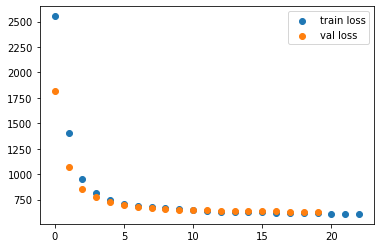

In [ ]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

In [ ]:
generated_samples = nfm.flow.sample(5)  # generative modeling
log_probs = nfm.flow.log_prob(generated_samples)  # probability density estimation

In [ ]:
mols = tf.math.floor(generated_samples)  # quantize data
mols = tf.clip_by_value(mols, 0, 1)  # Set negative values to 0 and values > 1 to 1
mols_list = mols.numpy().tolist()

# Add padding characters if needed
for mol in mols_list:
  for i in range(largest_selfie_len):
    row = mol[len(selfies_alphabet) * i: len(selfies_alphabet) * (i + 1)]
    if all(elem == 0 for elem in row):
      try:
        mol[len(selfies_alphabet) * (i+1) - 1] = 1
      except:
        #print("descarto los nopx que había agregado")
        pass

In [ ]:
mols = sf.batch_flat_hot_to_selfies(mols_list, selfies_alphabet)

In [ ]:
mols[1]

'[Hexpl][/N+expl][#C][=C][=O][Branch2_2][Branch1_2][Branch1_1][=C][nop][Branch1_1][=N+expl][Branch1_1][C][C][Branch1_1][nop][Hexpl][=N+expl][=C][=C][Branch1_1][=C][=O][nop][C][Branch2_3][=N+expl][/Hexpl][=N+expl][#N][#C][Branch2_1][=O][Branch1_3][Branch1_1][C-expl][Branch1_1][nop][=N][=O][Branch2_3][Branch2_3][=C][Branch1_2][Branch1_1][nop][Cexpl][#N][/N+expl][NH+expl][#N][O][Expl=Ring2][C+expl][/O][Branch2_3][=O][Branch1_3][O-expl][nop][/N+expl]'

In [ ]:
from rdkit import RDLogger  
from rdkit import Chem
RDLogger.DisableLog('rdApp.*')  # suppress error messages

valid_count = 0
valid_selfies, invalid_selfies = [], []
for idx, selfies in enumerate(mols):
  try:
    if Chem.MolFromSmiles(sf.decoder(mols[idx]), sanitize=True) is not None:
        valid_count += 1
        valid_selfies.append(selfies)
    else:
      invalid_selfies.append(selfies)
  except Exception:
    pass
print('%.2f' % (100 * valid_count / len(mols)),  '% of generated samples are valid molecules.')

100.00 % of generated samples are valid molecules.


In [ ]:
gen_mols = [Chem.MolFromSmiles(sf.decoder(vs)) for vs in valid_selfies]

In [ ]:
gen_mols

In [ ]:

def display_images(filenames):
    """Helper to pretty-print images."""
    for file in filenames:
      display(Image(file))

def mols_to_pngs(mols, basename="generated_mol"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

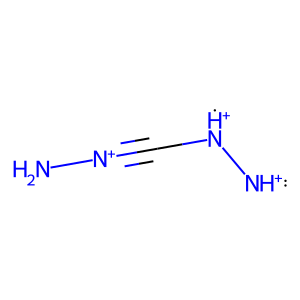

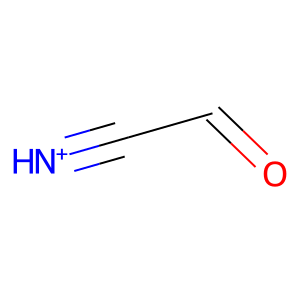

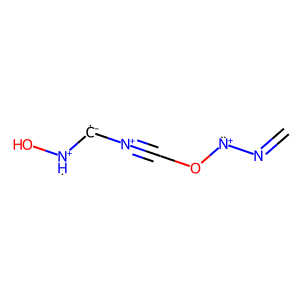

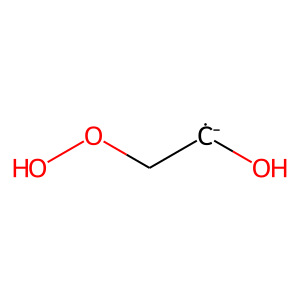

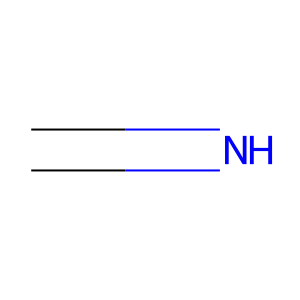

In [ ]:

display_mols = []
for i in range(len(gen_mols)):
  display_mols.append(gen_mols[i])

display_images(mols_to_pngs(display_mols))

In [ ]:
from rdkit.Chem.Fingerprints.FingerprintMols import FingerprintMol
from rdkit.DataStructs import FingerprintSimilarity
from IPython.display import display

def tanimoto_similarity(database_mols, query_mol):
    """Compare generated molecules to database by Tanimoto similarity."""
    # convert Mol to datastructure type
    fps = [FingerprintMol(m) for m in database_mols]
    
    # set a query molecule to compare against database
    query = FingerprintMol(query_mol)
    
    similarities = []
    
    # loop through to find Tanimoto similarity
    for idx, f in enumerate(fps):
        # tuple: (idx, similarity)
        similarities.append((idx, FingerprintSimilarity(query, f)))
    
    # sort sim using the similarities
    similarities.sort(key=lambda x:x[1], reverse=True)
    
    return similarities

In [ ]:
train_mols = [Chem.MolFromSmiles(smiles) for smiles in train_smiles]

In [ ]:
def displaySimilares(tanimoto_scores, similar_mols):

  for x in range(3):
      #print(round(tanimoto_scores[x], 3))
      pass
  display_images(mols_to_pngs(similar_mols, 'qm9_mol'))

REVISANDO MOLECULA: 0


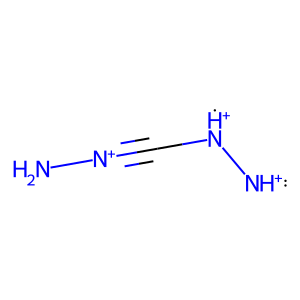

LASM MOLECULAS MAS PARECIDAS ENCONTRADAS SON:
0.366
0.343
0.333


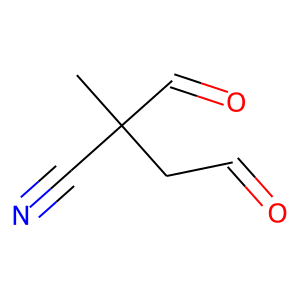

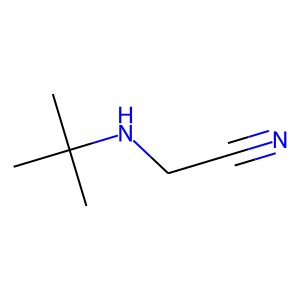

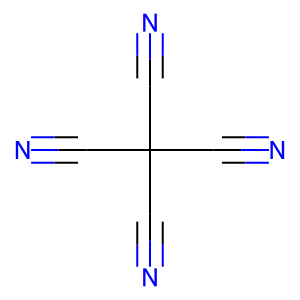

REVISANDO MOLECULA: 1


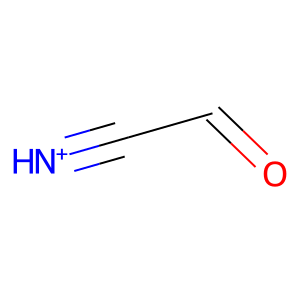

LASM MOLECULAS MAS PARECIDAS ENCONTRADAS SON:
0.333
0.321
0.3


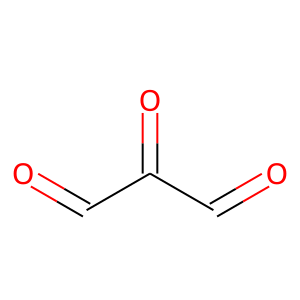

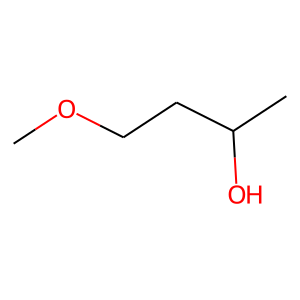

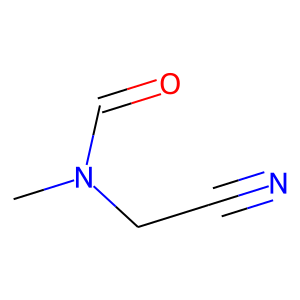

REVISANDO MOLECULA: 2


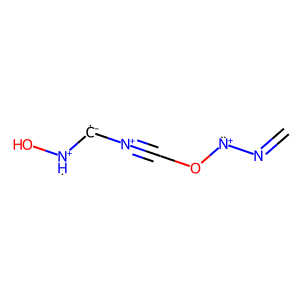

LASM MOLECULAS MAS PARECIDAS ENCONTRADAS SON:
0.49
0.46
0.454


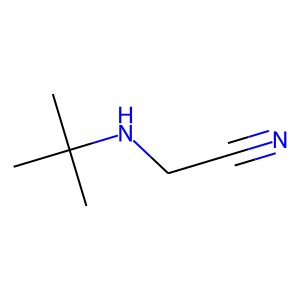

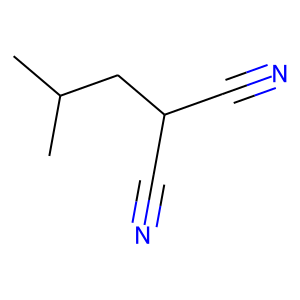

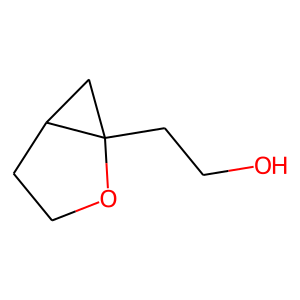

REVISANDO MOLECULA: 3


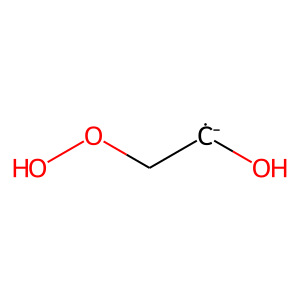

LASM MOLECULAS MAS PARECIDAS ENCONTRADAS SON:
0.312
0.31
0.3


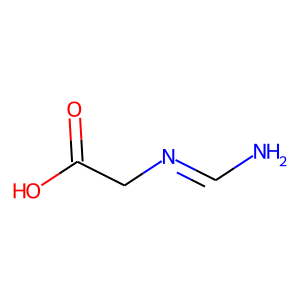

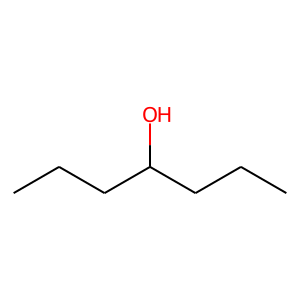

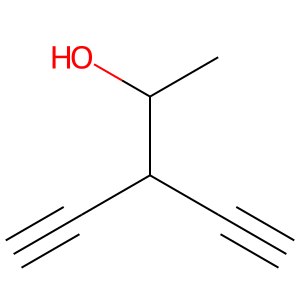

REVISANDO MOLECULA: 4


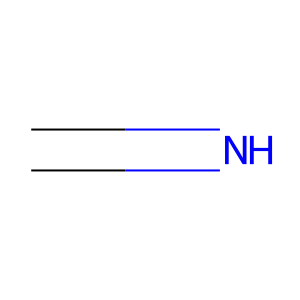

LASM MOLECULAS MAS PARECIDAS ENCONTRADAS SON:
0.095
0.077
0.069


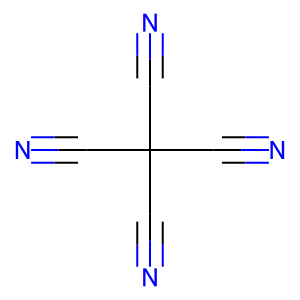

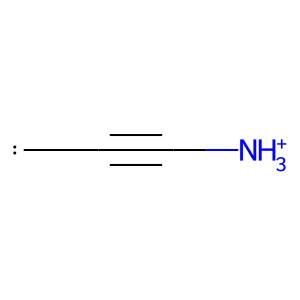

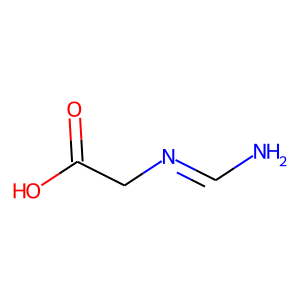

In [ ]:

for i in range(len(gen_mols)):
  print("REVISANDO MOLECULA:", i)
  display_images(mols_to_pngs([gen_mols[i]]))
  print("LASM MOLECULAS MAS PARECIDAS ENCONTRADAS SON:")
  # change the second argument to compare different generated molecules to QM9
  tanimoto_scores = tanimoto_similarity(train_mols, gen_mols[i])
  similar_mols = []
  for idx, ts in tanimoto_scores[:3]:
      print(round(ts, 3))
      similar_mols.append(train_mols[idx])
   
  displaySimilares(tanimoto_scores, similar_mols)